# Feature Engineering

### Import Libraries

In [73]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

#Model Creation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter

### Import data

In [32]:
final_df = pd.read_csv('data/final_df.csv',index_col = 0)

In [33]:
final_df.dtypes

Season                     int64
Week_Number                int64
Week_Name                 object
Baker                     object
Gender                    object
Age                        int64
Signature_Handshake        int64
Technical_Rank             int64
Showstopper_Handshake      int64
Favorite                 float64
Least_Favorite             int64
Star_Baker                 int64
Eliminated                 int64
Winner                     int64
signature                 object
showstopper               object
dtype: object

### Create a table of winners for future reference

In [24]:
Table_of_Winners = final_df.loc[final_df.Winner == 1]

In [29]:
Table_of_Winners = Table_of_Winners[['Season','Baker']].drop_duplicates()

In [31]:
Table_of_Winners.to_csv('data/Table_of_Winners.csv')

After understanding my data better:
- It seems the winner decided by whoever wins the final star baker. Therefore I will remove Winner from my dataset and set the target feature to Star Baker.
- Week_Name is redundant with Week_Number. I'll remove Week_Number
- We don't need the names of the bakers.

### Drop Week_Number, Baker, Winner

In [35]:
df = final_df.drop(columns=['Week_Number','Baker','Winner'])

In [53]:
df = df.astype({'Season':'category',
                       'Week_Name':'category',
                       'Gender':'category'})
df.dtypes

Season                   category
Week_Name                category
Gender                   category
Age                         int64
Signature_Handshake         int64
Technical_Rank              int64
Showstopper_Handshake       int64
Favorite                  float64
Least_Favorite              int64
Star_Baker                  int64
Eliminated                  int64
signature                  object
showstopper                object
dtype: object

### Get my split ready

In [54]:
X = df.drop(columns='Star_Baker')
y= df['Star_Baker'].values

In [55]:
#is our class unbalanced?
df.Star_Baker.value_counts()

0    576
1     88
Name: Star_Baker, dtype: int64

In [56]:
#test_size of 30%. Also the target variable is unbalanced so i'll set stratify = y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0,stratify =y )

In [57]:
#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)
sig_text = ('signature')
show_text = ('showstopper')

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        ('num',StandardScaler(),num_cols),
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols),
        ('text_sig',TfidfVectorizer(max_features=50),sig_text),
        ('text_show',TfidfVectorizer(max_features=50),show_text)
    ], remainder='passthrough')

In [61]:
#Fit and Transform our Training and Testing Data
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

In [66]:
#View our transformed X_train_trans
pd.DataFrame(X_train_trans.toarray(),columns=preprocessor.get_feature_names_out())

,num__Age,num__Signature_Handshake,num__Technical_Rank,num__Showstopper_Handshake,num__Favorite,num__Least_Favorite,num__Eliminated,cat__Season_2,cat__Season_3,cat__Season_4,...,text_show__sculpture,text_show__spiced,text_show__tart,text_show__tarts,text_show__the,text_show__to,text_show__tower,text_show__walnut,text_show__white,text_show__with
0,-0.592962,-0.228373,-1.290162,-0.08067,-0.576523,-0.590624,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
1,2.058561,-0.228373,1.073316,-0.08067,-0.576523,1.693123,-0.410811,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.69731,0.0,0.0
2,0.732799,-0.228373,-1.290162,-0.08067,-0.576523,-0.590624,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
3,0.108911,-0.228373,0.060397,-0.08067,-0.576523,-0.590624,-0.410811,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
4,0.108911,-0.228373,-1.290162,-0.08067,1.739551,-0.590624,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,-0.281018,-0.228373,-0.952523,-0.08067,1.739551,-0.590624,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0
460,-0.436990,-0.228373,1.410956,-0.08067,-0.576523,-0.590624,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,1.0
461,-0.748934,-0.228373,-0.952523,-0.08067,-0.576523,1.693123,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.463091,0.626716,0.0,0.00000,0.0,0.0
462,0.108911,-0.228373,0.398037,-0.08067,-0.576523,-0.590624,-0.410811,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0


# Model Creation

### RandomForest

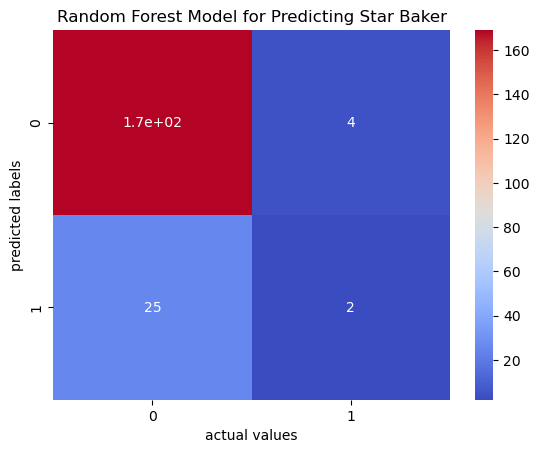

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       173
           1       0.33      0.07      0.12        27

    accuracy                           0.85       200
   macro avg       0.60      0.53      0.52       200
weighted avg       0.80      0.85      0.81       200

The training score for the random forest model is 1.0     
and the testing score for the model is 0.855


In [74]:
#RandomForest

rf = RandomForestClassifier(n_estimators = 300, random_state = 1, n_jobs=-1)

#fit
model = rf.fit(X_train_trans,y_train)

#pred
y_pred = model.predict(X_test_trans)

#confusion matrix
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('actual values')
plt.ylabel('predicted labels')
plt.title('Random Forest Model for Predicting Star Baker')
plt.show()

print(classification_report(y_test,y_pred))

#scores

training_score = (rf.score(X_train_trans,y_train))
testing_score = (rf.score(X_test_trans, y_test))

print(f'The training score for the random forest model is {training_score}\
     \nand the testing score for the model is {testing_score}')

### Creating a table to store model outputs

In [76]:
Model_Data_Frame = pd.DataFrame({"Random Forest": [training_score,testing_score]})
index_name = ['Training','Testing']
Model_Data_Frame.index=index_name
Model_Data_Frame

,Random Forest
Training,1.000
Testing,0.855


### Logistic Regression

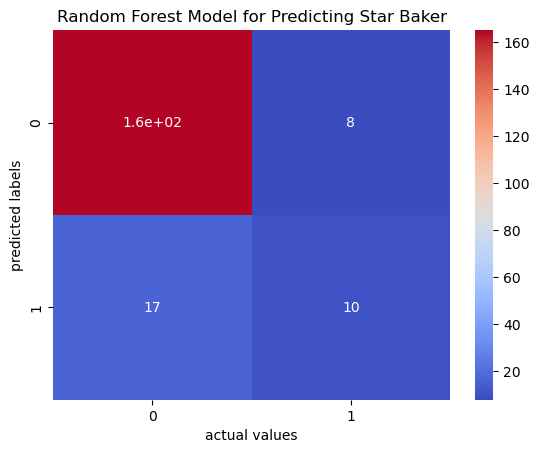

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       173
           1       0.56      0.37      0.44        27

    accuracy                           0.88       200
   macro avg       0.73      0.66      0.69       200
weighted avg       0.86      0.88      0.86       200

The training score for the Logistic Regression model is 0.9288793103448276     
and the testing score for the model is 0.875


In [77]:

#is this the right solver / max_iter?
logreg = LogisticRegression(solver= 'liblinear',max_iter = 500)
logreg.fit(X_train_trans,y_train)
y_pred_logreg = logreg.predict(X_test_trans)

#confusion matrix
cm = confusion_matrix(y_test,y_pred_logreg)

sns.heatmap(cm,annot=True,cmap='coolwarm')
plt.xlabel('actual values')
plt.ylabel('predicted labels')
plt.title('Random Forest Model for Predicting Star Baker')
plt.show()

print(classification_report(y_test,y_pred_logreg))

#scores

training_score = (logreg.score(X_train_trans,y_train))
testing_score = (logreg.score(X_test_trans, y_test))

print(f'The training score for the Logistic Regression model is {training_score}\
     \nand the testing score for the model is {testing_score}')

In [78]:
Model_Data_Frame['Logistic Regression']=[training_score,testing_score]

### Gradient Boosting

In [81]:
learning_rate = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
n_estimators = [18,19,20,21,22]
max_depth = [1,2,3]
params = ({'learning_rate': learning_rate,
          'n_estimators' : n_estimators,
          'max_depth': max_depth})


In [82]:
gb = GradientBoostingClassifier()
cv = GridSearchCV(gb,params, cv=5)
cv.fit(X_train_trans,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [18, 19, 20, 21, 22]})

In [83]:
training =cv.score(X_train_trans, y_train)
testing =cv.score(X_test_trans, y_test)

print("Accuracy score (training): {0:.3f}".format(training))
print("Accuracy score (validation): {0:.3f}".format(testing))


Accuracy score (training): 0.892
Accuracy score (validation): 0.875


In [84]:
Model_Data_Frame['Gradient Boosting (w/CV)']=[training,testing]

### KNN

In [85]:

simplefilter(action='ignore', category=FutureWarning) # to deal with annoying future warning
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train_trans,y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [86]:
training =knn_cv.score(X_train_trans, y_train)
testing =knn_cv.score(X_test_trans, y_test)

print("Accuracy score (training): {0:.3f}".format(training))
print("Accuracy score (validation): {0:.3f}".format(testing))


Accuracy score (training): 0.875
Accuracy score (validation): 0.865


In [87]:
Model_Data_Frame['KNN (w/CV)']=[training,testing]

In [88]:
Model_Data_Frame

,Random Forest,Logistic Regression,Gradient Boosting (w/CV),KNN (w/CV)
Training,1.000,0.928879,0.892241,0.875
Testing,0.855,0.875000,0.875000,0.865
